In [53]:
import pandas as pd

In [54]:
def check_dataset(dataset, mode='shape'):
    if mode == 'info':
        print(dataset.info())
    elif mode == 'head':
        print(dataset.head())
    elif mode == 'shape':
        print(f"{dataset.shape}")
    else:
        raise ValueError("Invalid mode. Use 'info', 'head' or 'shape'.")

In [55]:
# one-hot encoding

def one_hot_encoding(data):
    non_numerial_columns = ['protocol_type', 'service', 'flag']
    data_encoded = pd.get_dummies(data, columns=non_numerial_columns, drop_first=True, dtype=int) # drop first: 忽略資料標題
    
    return data_encoded

In [56]:
# Normalization

from sklearn.preprocessing import MinMaxScaler

def normalization(data):
    scaler = MinMaxScaler()
    
    features = data.drop(columns=['label'])
    
    feature_encoded = pd.DataFrame(scaler.fit_transform(features),
                                   columns=features.columns,
                                   index=features.index)
    
    data = pd.concat([feature_encoded, data['label']], axis=1)
    
    return data

In [57]:
def change_label(df):
    """
        將 label 轉換成 5 類別：
        DoS, R2L, Probe, U2R, Normal
    """
    df = df.copy()
    
    df['label'] = df.label.replace([
        'apache2','back','land','neptune','mailbomb','pod','processtable',
        'smurf','teardrop','udpstorm','worm'
    ], 'DoS')

    df['label'] = df.label.replace([
        'ftp_write','guess_passwd','httptunnel','imap','multihop','named',
        'phf','sendmail','snmpgetattack','snmpguess','spy','warezclient',
        'warezmaster','xlock','xsnoop'
    ], 'R2L')      

    df['label'] = df.label.replace([
        'ipsweep','mscan','nmap','portsweep','saint','satan'
    ], 'Probe')

    df['label'] = df.label.replace([
        'buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'
    ], 'U2R')

    # 其餘未列入的視為 'Normal'
    df['label'] = df.label.where(df.label.isin(['DoS', 'R2L', 'Probe', 'U2R']), 'Normal')
    
    return df


In [58]:
import matplotlib.pyplot as plt

def label_distribution(data1, data2):
    """
        繪製資料集的標籤分佈圖
    """
    data1_counts = data1['label'].value_counts()
    data2_counts = data2['label'].value_counts()
    
    combined  = pd.DataFrame({
        'Train': data1_counts,
        'Test': data2_counts
    }).fillna(0) # 若某些 label 在其中一個資料集中缺少，填 0
    
    # 自訂排序
    order = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
    
    combined = combined.reindex(order)
    
    # 繪製圖形
    combined.plot(kind='bar', figsize=(12, 6))
    plt.title('NSL-KDD Train vs Test Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45) 
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

In [59]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'label'
,'level'])


In [60]:
# 載入NSL-KDD資料集

# 訓練資料集讀取
train_dataset = pd.read_csv('C:/Users/hansc/OneDrive/School/專題製作/Code/NSL-KDD Dataset/KDDTrain+.csv', encoding='utf-8')
train_dataset.columns = columns
train_dataset = train_dataset.drop(columns=['level']) # 去除 level 欄位
train_dataset_header = list(train_dataset.columns) 
train_dataset = pd.DataFrame(data=train_dataset, columns=train_dataset_header)

# 測試資料集讀取
test_dataset = pd.read_csv('C:/Users/hansc/OneDrive/School/專題製作/Code/NSL-KDD Dataset/KDDTest+.csv', encoding='utf-8')
test_dataset.columns = columns
test_dataset = test_dataset.drop(columns=['level']) # 去除 level 欄位
test_dataset_header = list(test_dataset.columns)
test_dataset = pd.DataFrame(data=test_dataset, columns=test_dataset_header)

check_dataset(train_dataset)
check_dataset(test_dataset)

(125972, 42)
(22542, 42)


In [61]:
train_dataset = one_hot_encoding(train_dataset)
test_dataset = one_hot_encoding(test_dataset)

check_dataset(train_dataset)
check_dataset(test_dataset)

(125972, 120)
(22542, 113)


In [62]:
# Normalization

train_dataset = normalization(train_dataset)
test_dataset = normalization(test_dataset)

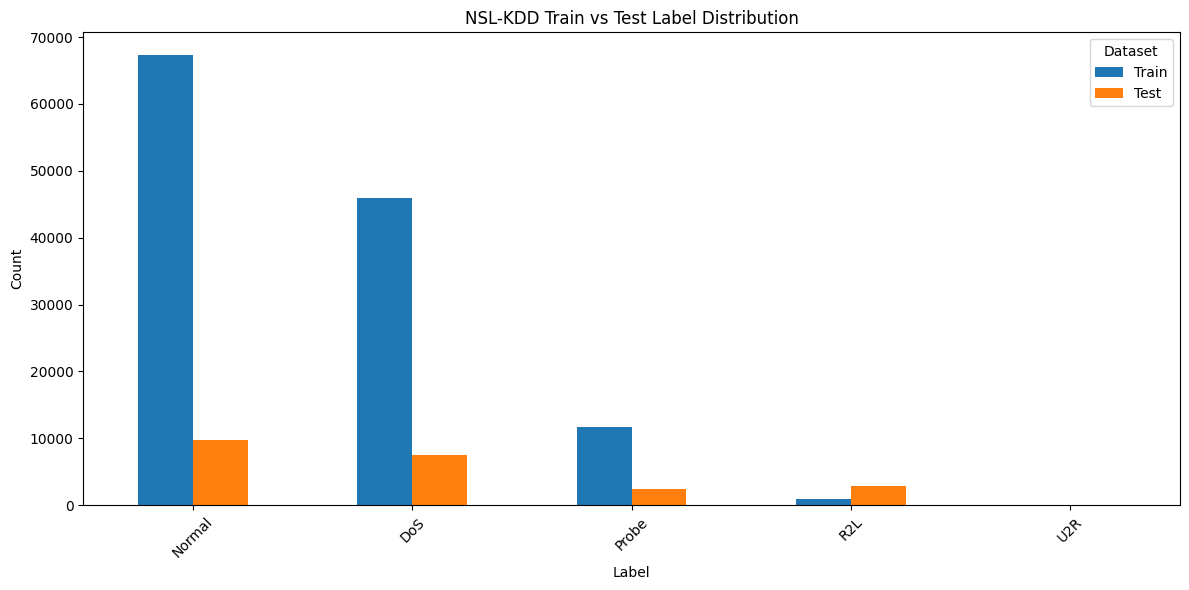

In [63]:
# Label Change
import matplotlib.pyplot as plt

train_dataset = change_label(train_dataset)
test_dataset = change_label(test_dataset)

label_distribution(train_dataset, test_dataset)

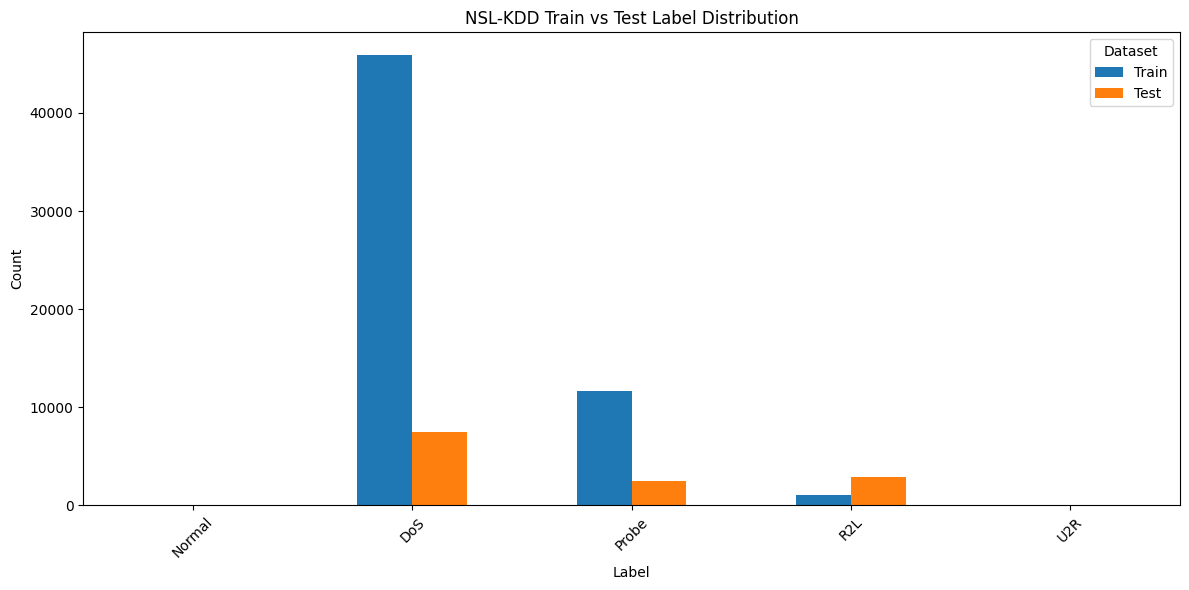

In [64]:
# Drop Normal data

train_dataset = train_dataset[train_dataset['label'] != 'Normal']
test_dataset = test_dataset[test_dataset['label'] != 'Normal']

label_distribution(train_dataset, test_dataset)

In [65]:
# 訓練的題目與答案
X_train = train_dataset.drop(columns=['label']) 
Y_train = train_dataset['label'] 

# 測試的題目與答案
X_test = test_dataset.drop(columns=['label']) 
Y_test = test_dataset['label'] 

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder

train_dataset_distribution_before = train_dataset['label'].value_counts()

oversampler = ADASYN() # sampling_strategy: 欲平衡的類別比例, random_state: 隨機種子, n_neighbors: 近鄰數量
label_encoder = LabelEncoder()

Y_train_encoded = label_encoder.fit_transform(Y_train) 
Y_test_encoded = label_encoder.transform(Y_test)

X_train, Y_train = oversampler.fit_resample(X_train, Y_train_encoded) # 進行過採樣

resampled_attack_labels = label_encoder.inverse_transform(Y_train) # 將編碼的標籤轉回原始標籤
pd.Series(resampled_attack_labels).value_counts()



DoS      45927
R2L      45925
U2R      45924
Probe    45905
Name: count, dtype: int64

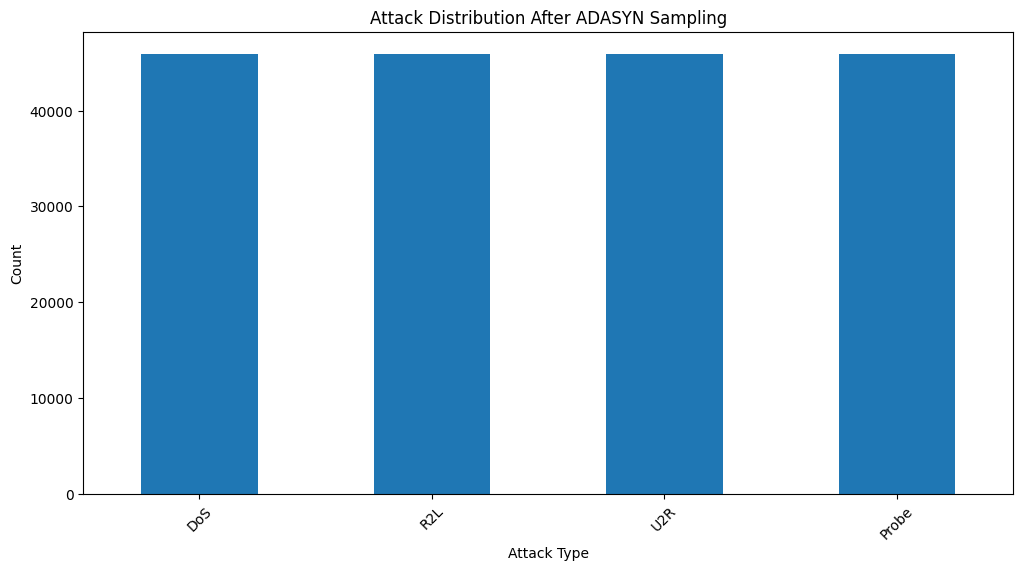

In [67]:
pd.Series(resampled_attack_labels).value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Attack Distribution After ADASYN Sampling')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
# label_distribution(resampled_attack_labels) # 繪製過採樣後的標籤分佈圖

In [68]:
# from imblearn.under_sampling import TomekLinks

# undersampler = TomekLinks(sampling_strategy='majority', random_state=42)

In [ ]:
#傳入參數


#總資料筆數
row_num = X_train.shape[0]
max_initial_size = int(row_num * 3/4)

print(row_num)
print(max_initial_size)

183681
137760


In [ ]:
from evobagging_methods import *

bag = EvoBagging(
    X_train=X_train,
    y_train=Y_train,
    n_select= 0, # 每一代選擇的袋子數量
    n_new_bags= 0, # 每一代新增的袋子數量
    max_initial_size= max_initial_size, # 初始袋子大小
    n_crossover= 0, # 每一代交配的袋子數量
    n_mutation= 0, # 每一代突變的袋子數量
    size_coef= 0, # 袋子大小係數
    metric= 'accuracy', # 評估指標
    procs= 1, # 使用的處理器數量
)

In [ ]:
check_dataset(train_dataset, mode='head')

   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
1       0.0        0.0        0.0   0.0             0.0     0.0  0.0   
4       0.0        0.0        0.0   0.0             0.0     0.0  0.0   
5       0.0        0.0        0.0   0.0             0.0     0.0  0.0   
6       0.0        0.0        0.0   0.0             0.0     0.0  0.0   
7       0.0        0.0        0.0   0.0             0.0     0.0  0.0   

   num_failed_logins  logged_in  num_compromised  ...  flag_RSTO  flag_RSTOS0  \
1                0.0        0.0              0.0  ...        0.0          0.0   
4                0.0        0.0              0.0  ...        0.0          0.0   
5                0.0        0.0              0.0  ...        0.0          0.0   
6                0.0        0.0              0.0  ...        0.0          0.0   
7                0.0        0.0              0.0  ...        0.0          0.0   

   flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  flag_SH  label  
1   

In [ ]:
check_dataset(test_dataset, mode='head')

   duration     src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0  0.000000  0.000000e+00   0.000000   0.0             0.0     0.0  0.0   
2  0.000000  3.183413e-07   0.000000   0.0             0.0     0.0  0.0   
3  0.000017  0.000000e+00   0.000011   0.0             0.0     0.0  0.0   
6  0.000000  2.053302e-06   0.000129   0.0             0.0     0.0  0.0   
8  0.000000  4.138437e-07   0.000117   0.0             0.0     0.0  0.0   

   num_failed_logins  logged_in  num_compromised  ...  flag_RSTO  flag_RSTOS0  \
0               0.00        0.0              0.0  ...        0.0          0.0   
2               0.00        0.0              0.0  ...        0.0          0.0   
3               0.00        0.0              0.0  ...        1.0          0.0   
6               0.25        0.0              0.0  ...        0.0          0.0   
8               0.25        0.0              0.0  ...        0.0          0.0   

   flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  fla